About the Dataset:
 The dataset is taken from this Kaggle notebook: [Diamond Price Prediction](https://www.kaggle.com/code/karnikakapoor/diamond-price-prediction/notebook)

 Features:
 1. Carat - weight of the diamond (0.2 - 5.01)
 2. cut - quality of the cut (Fair, Good, Very Good, Premium, Ideal)
 3. color - j (worst) to d (best)
 4. clarity - I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)
 5. x - length in mm
 6. y - width in mm
 7. z - depth  in mm
 8. depth - total depth percentage
 9. table - width of top of diamond relative to widest point
 10. price - price in US dollars


In [35]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Datasets/Diamonds/diamonds.csv')
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


<Axes: xlabel='cut', ylabel='Count'>

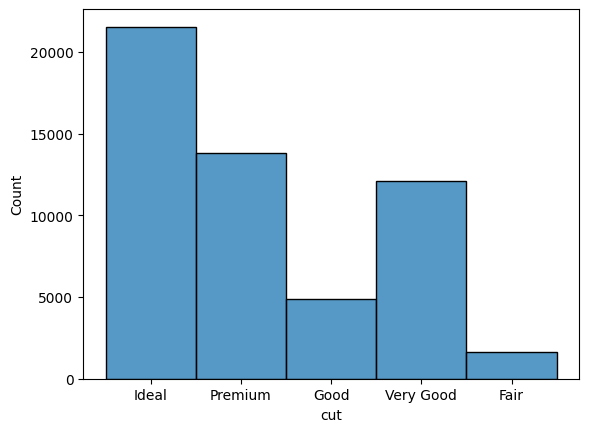

In [5]:
sns.histplot(df['cut'], stat = 'count')

<Axes: xlabel='color', ylabel='Count'>

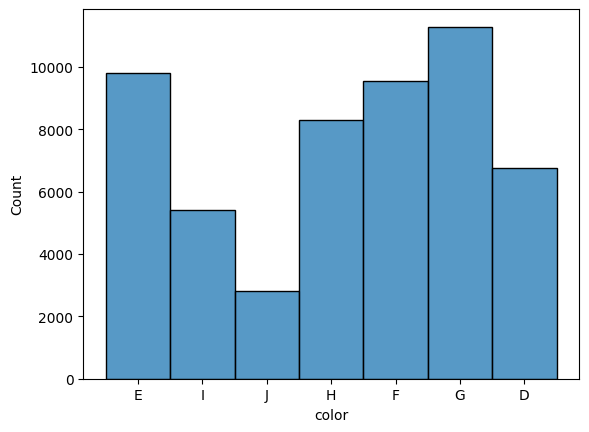

In [6]:
sns.histplot(df['color'], stat = 'count')

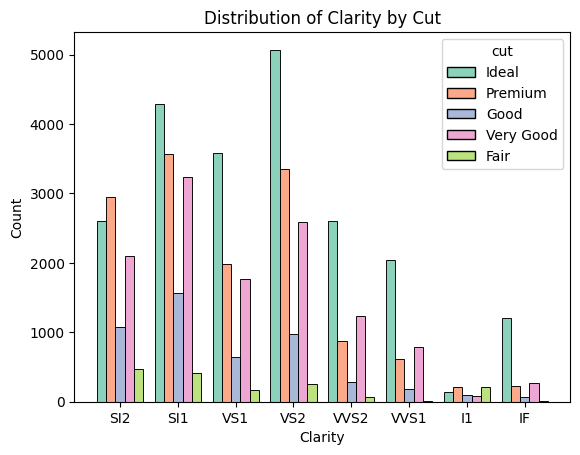

In [7]:
sns.histplot(data = df,
             x = 'clarity',
             hue = 'cut',
             multiple = 'dodge',
             shrink = 0.8,
             palette = 'Set2')

plt.title('Distribution of Clarity by Cut')
plt.xlabel('Clarity')
plt.ylabel('Count')
plt.show()

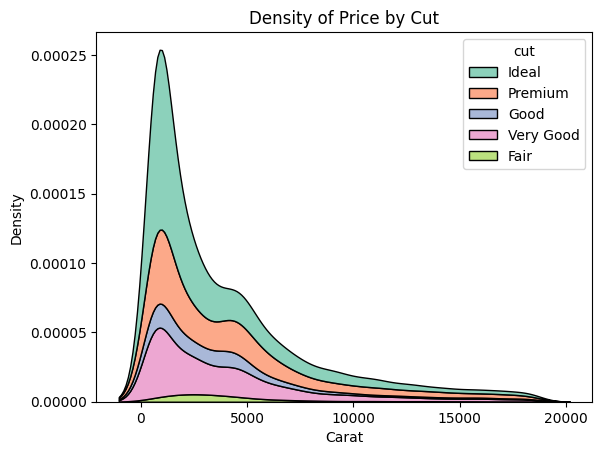

In [8]:
sns.kdeplot(
    data = df,
    x = 'price',
    hue = 'cut',
    multiple = 'stack',
    palette = 'Set2'
)

plt.title  ('Density of Price by Cut')
plt.xlabel('Carat')
plt.ylabel('Density')
plt.show()

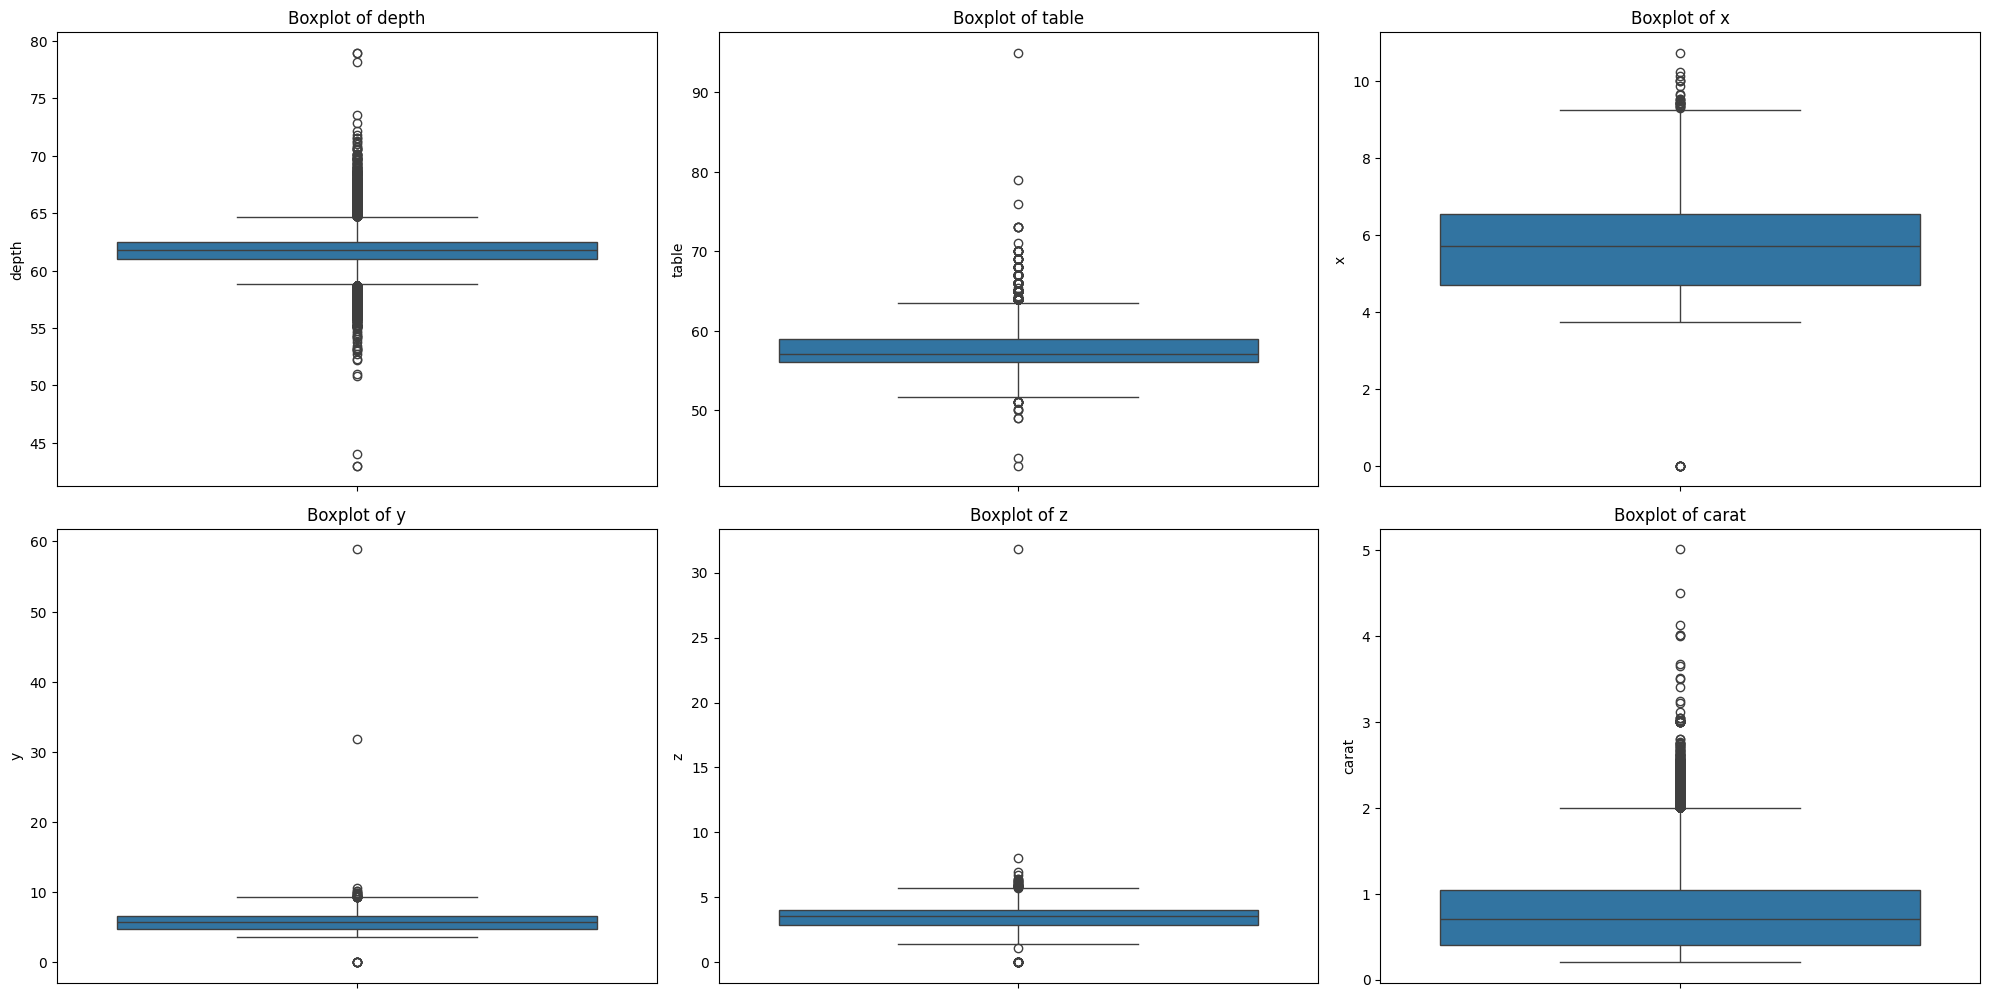

In [9]:
numeric_columns = ['depth', 'table', 'x', 'y', 'z', 'carat']

plt.figure(figsize = (20, 15))
for i, column in enumerate(numeric_columns, 1):
  plt.subplot(3, 3, i)
  sns.boxplot(df[column])
  plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

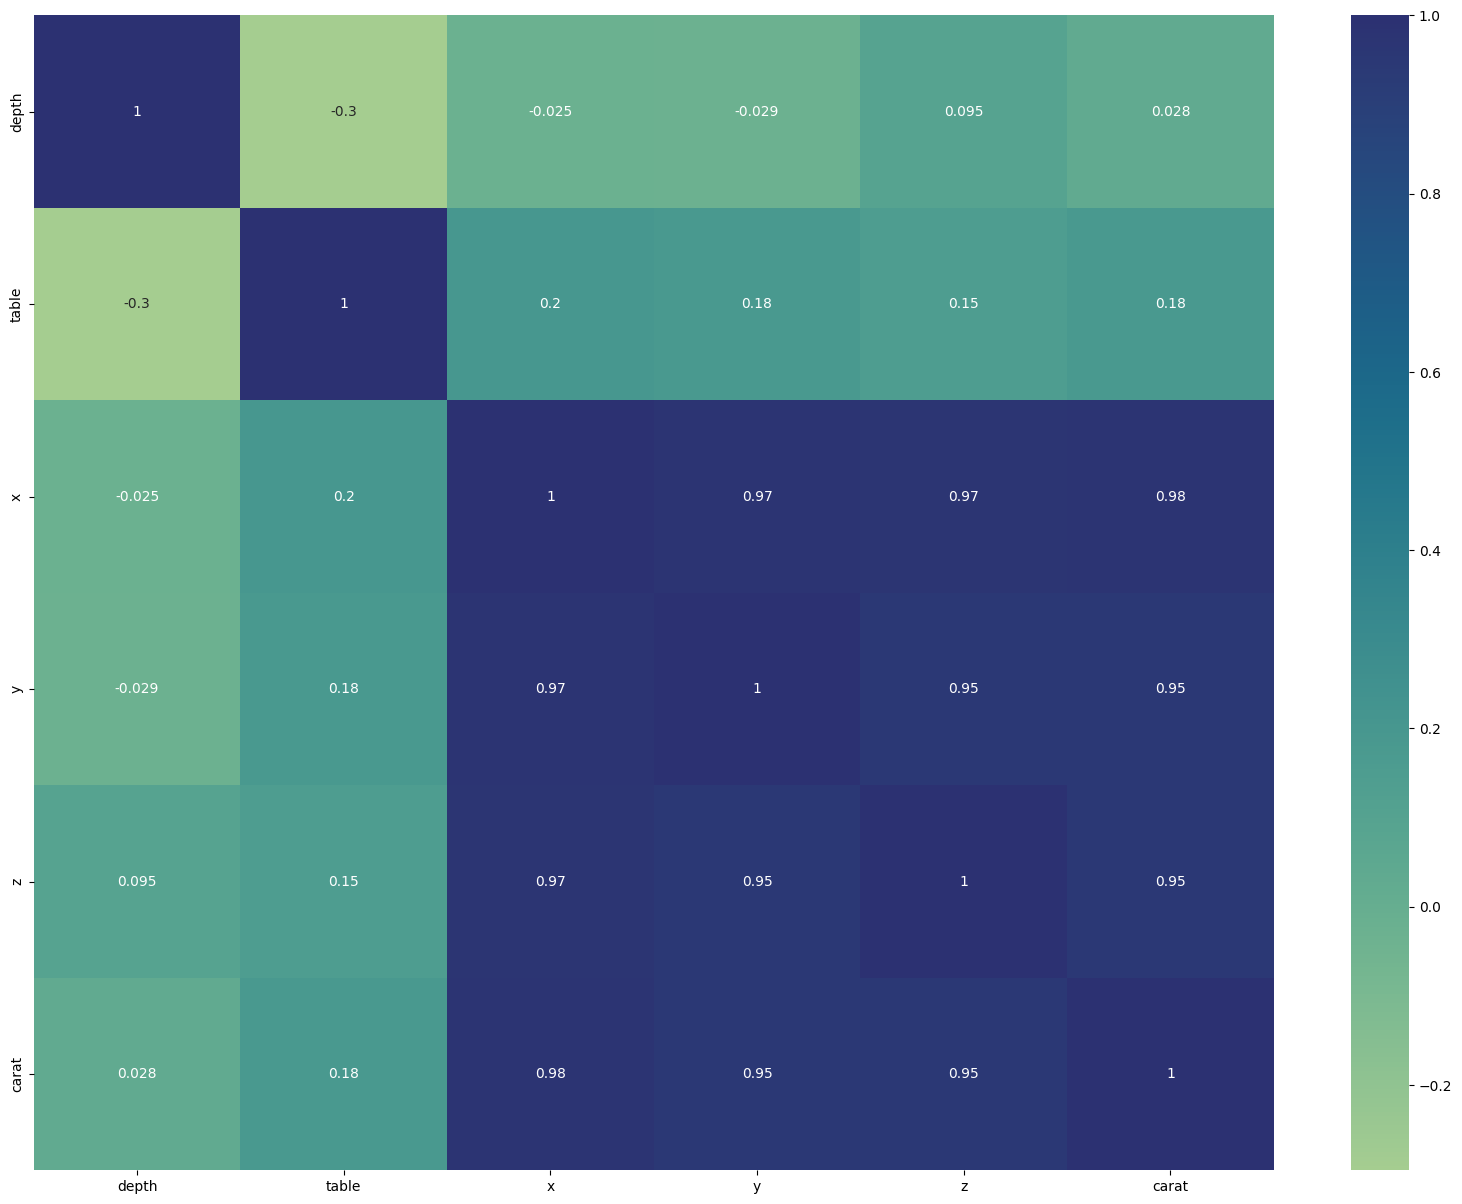

In [10]:
corr_matrix = df[numeric_columns].corr()

plt.figure(figsize = (20, 15))
sns.heatmap(corr_matrix, annot = True, cmap = 'crest')
plt.show()

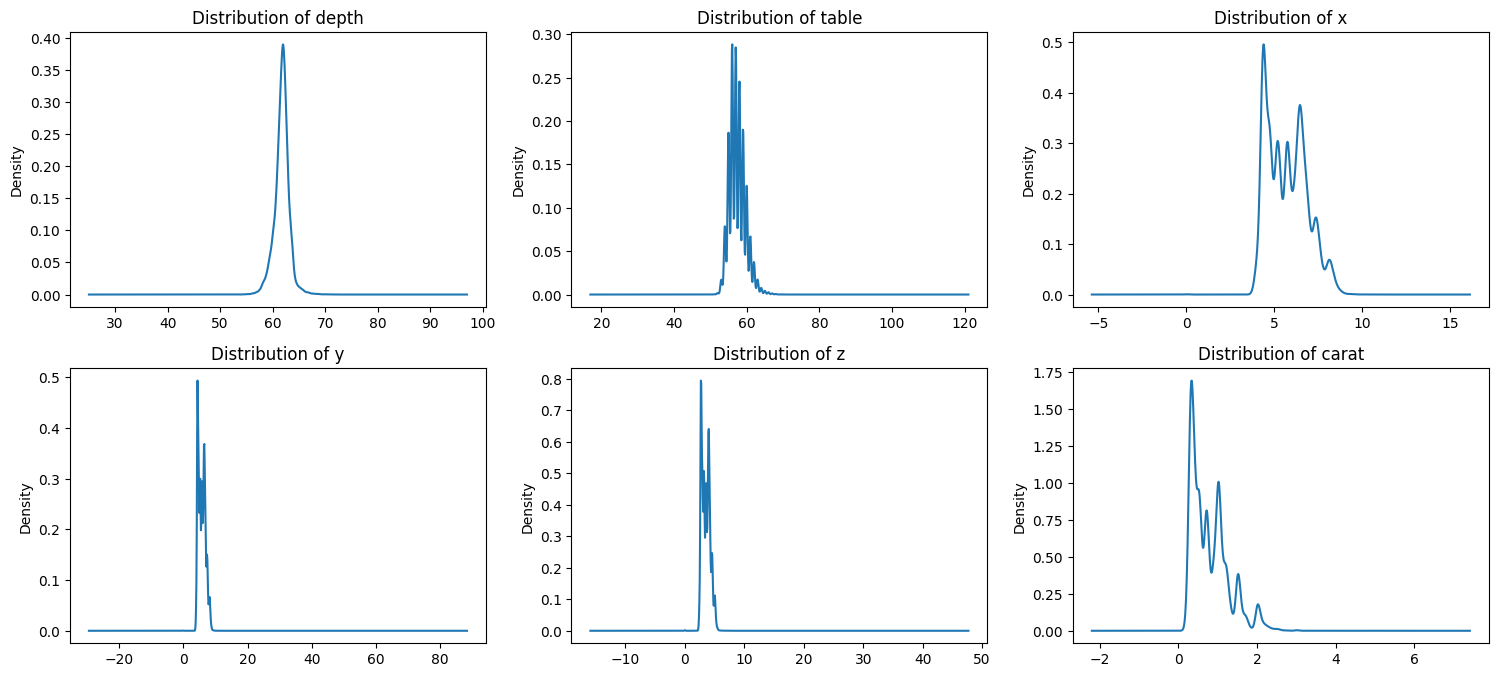

In [11]:
plt.figure(figsize = (15, 10))
for i, column in enumerate(numeric_columns, 1):
  plt.subplot(3, 3, i)
  df[numeric_columns[i-1]].plot.kde()
  plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

**Data Preprocessing**

In [12]:
df.columns

Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'],
      dtype='object')

In [13]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [14]:
df['clarity'] = df['clarity'].map({
    'I1': 0,
    'SI2': 1,
    'SI1': 2,
    'VS2': 3,
    'VS1': 4,
    'VVS2': 5,
    'VVS1': 6,
    'IF': 7
})

In [15]:
df['color'].unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

In [16]:
df['color'] = df['color'].map({
    'J': 0,
    'I': 1,
    'H': 2,
    'G': 3,
    'F': 4,
    'E': 5,
    'D': 6,
})

In [17]:
df['cut'] = df['cut'].map({
    'Fair': 0,
    'Good': 1,
    'Very Good': 2,
    'Premium': 3,
    'Ideal': 4,
})

In [18]:
## reducing features due to high correlation coefficient
## note: removing x, y, z leads to lower cross validation accuracy
df.drop(['y', 'z'], axis = 1, inplace = True)

In [19]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x'], dtype='object')

In [20]:
df.head()

,carat,cut,color,clarity,depth,table,price,x
0,0.23,4,5,1,61.5,55.0,326,3.95
1,0.21,3,5,2,59.8,61.0,326,3.89
2,0.23,1,5,4,56.9,65.0,327,4.05
3,0.29,3,1,3,62.4,58.0,334,4.20
4,0.31,1,0,1,63.3,58.0,335,4.34


In [21]:
df['carat-log'] = np.log(df['carat'] + 1)
df['depth-log'] = np.log(df['depth'] + 1)
df['table-log'] = np.log(df['table'] + 1)

df.drop(['carat', 'depth', 'table'], axis = 1, inplace = True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cut        53940 non-null  int64  
 1   color      53940 non-null  int64  
 2   clarity    53940 non-null  int64  
 3   price      53940 non-null  int64  
 4   x          53940 non-null  float64
 5   carat-log  53940 non-null  float64
 6   depth-log  53940 non-null  float64
 7   table-log  53940 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.3 MB


**Training**

In [23]:
X = df.drop('price', axis = 1)
y = df['price']

In [25]:
## using kfold for data split
kfold = KFold(n_splits = 30, shuffle = True, random_state = 43)

**Linear Regression Model**

In [41]:
model = LinearRegression()

r2_scores = []
rmse_list = []

#best model's metrics
best_model = None
best_r2 = -np.inf
best_rmse = 0

#for graphing
best_y_test = None
best_y_pred = None

##taking the fold of the best model
n_fold = 0
counter = 0
for train_set, test_set in kfold.split(X, y):
  counter += 1

  X_train, X_test = X.iloc[train_set], X.iloc[test_set]
  y_train, y_test = y.iloc[train_set], y.iloc[test_set]

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  r2_scores.append(r2)
  rmse_list.append(rmse)

  if rmse >= best_rmse and r2 >= best_r2:
    best_rmse = rmse
    best_r2 = r2
    best_model = model
    best_y_test = y_test
    best_y_pred = y_pred
    n_fold = counter

print(f'R2 scores: {r2_scores}')
print(f'R2 average: {np.average(r2_scores)} \n')


print(f'RMSE scores: {rmse_list}')
print(f'RMSE average: {np.average(rmse_list)} \n')

print(f'Best model has R2 = {best_r2:.4f},and RMSE = {best_rmse}')

R2 scores: [0.8923968453026934, 0.8548452882463735, 0.888714153256285, 0.8870177197088247, 0.8893237691394446, 0.8660275731013483, 0.8958052077338619, 0.8924587582471456, 0.8934024856032674, 0.896157333084334, 0.8168652439913048, 0.8637590324133251, 0.8913016067042248, 0.8879037279589687, 0.8580946863343049, 0.8943065198899062, 0.8873571479552709, 0.843649548530338, 0.8916318212233064, 0.8980563145466129, 0.8779995706280329, 0.8890813416612887, 0.8927120796038701, 0.8880002495800414, 0.8980764953516117, 0.8890302097004884, 0.8948878291256965, 0.898032823497017, 0.8929025936727193, 0.891251907518765]
R2 average: 0.8833683294436891 

RMSE scores: [np.float64(1316.9826716212453), np.float64(1483.7887782551963), np.float64(1345.1540444116167), np.float64(1367.8507768064624), np.float64(1311.8344227067466), np.float64(1519.0449402896402), np.float64(1280.2578696503388), np.float64(1298.3702157292166), np.float64(1324.6163271476628), np.float64(1293.1769231712135), np.float64(1653.8664329891

**Plotting Best Fold in Linear Regression**

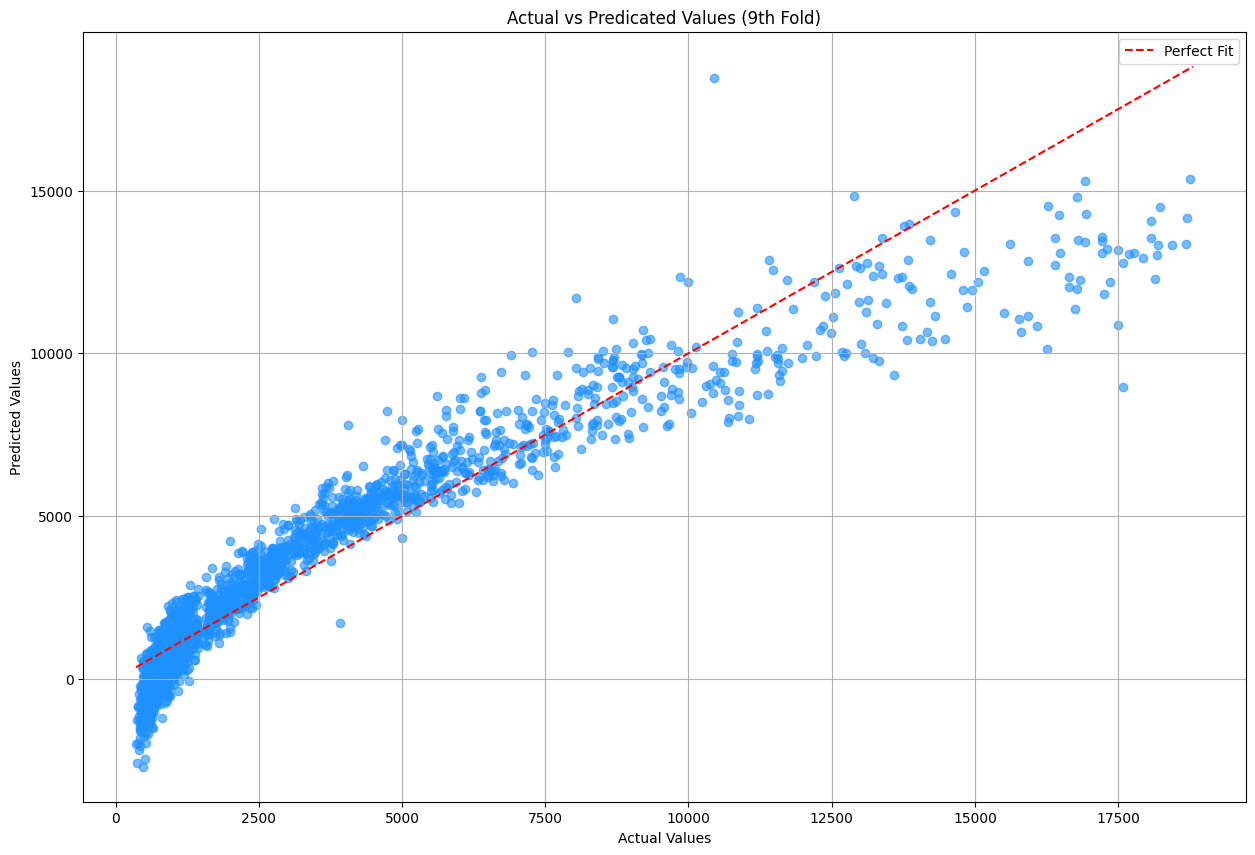

In [42]:
plt.figure(figsize = (15, 10))
plt.scatter(y_test, y_pred, color = 'dodgerblue', alpha = 0.6) #true values, predicted value
plt.plot([best_y_test.min(), best_y_test.max()],
 [best_y_test.min(), best_y_test.max()],
         color = 'red',
         linestyle = '--',
         label = 'Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicated Values ({n_fold}th Fold)')
plt.legend()
plt.grid(True)
plt.show()

**Random Forest Regressor Model**

In [43]:
rf = RandomForestRegressor()

r2_scores = []
rmse_list = []

#best model's metrics
best_model = None
best_r2 = -np.inf
best_rmse = 0

#for graphing
best_y_test = None
best_y_pred = None

##taking the fold of the best model
n_fold = 0
counter = 0
for train_set, test_set in kfold.split(X, y):
  counter += 1

  X_train, X_test = X.iloc[train_set], X.iloc[test_set]
  y_train, y_test = y.iloc[train_set], y.iloc[test_set]

  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)

  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  r2_scores.append(r2)
  rmse_list.append(rmse)

  if rmse >= best_rmse and r2 >= best_r2:
    best_rmse = rmse
    best_r2 = r2
    best_model = rf
    best_y_test = y_test
    best_y_pred = y_pred
    n_fold = counter

print(f'R2 scores: {r2_scores}')
print(f'R2 average: {np.average(r2_scores)} \n')


print(f'RMSE scores: {rmse_list}')
print(f'RMSE average: {np.average(rmse_list)} \n')

print(f'Best model has R2 = {best_r2:.4f},and RMSE = {best_rmse}')

R2 scores: [0.981181414767842, 0.9812819009424634, 0.9824868244785757, 0.982848754983163, 0.9791709458161684, 0.983636013982725, 0.9820794916480893, 0.9812573697037034, 0.9844745325418955, 0.9810786038509077, 0.9704716938624077, 0.9802930526764427, 0.9827993870051179, 0.9817817047012802, 0.9778640331003833, 0.9800395149448606, 0.9780079753793914, 0.9824724054107691, 0.9831064581460993, 0.980890118333374, 0.9816477712830219, 0.9820175698342526, 0.9840007988187894, 0.9816769759778379, 0.9811800751235434, 0.9826103303781537, 0.9808072912663264, 0.9837878749386032, 0.9797067242328328, 0.9792918606679387]
R2 average: 0.9811316489598988 

RMSE scores: [np.float64(550.7582912377817), np.float64(532.8284234864958), np.float64(533.6229563924744), np.float64(532.9437569293729), np.float64(569.0974206452189), np.float64(530.8935634729199), np.float64(530.9450914041764), np.float64(542.0337017010525), np.float64(505.5206577440736), np.float64(552.0095847107525), np.float64(664.1012736033682), np.f

**Plotting Best Fold in Random Forest Regressor**

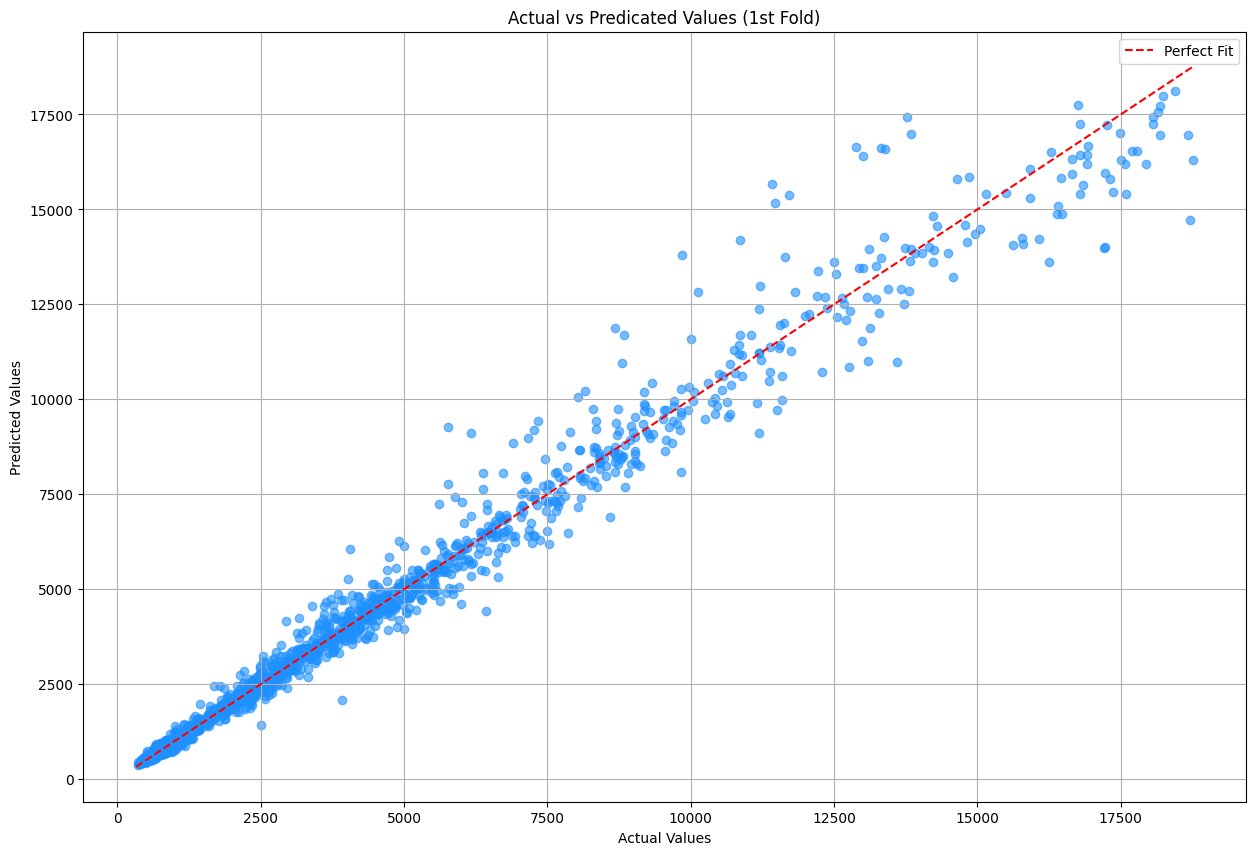

In [45]:
plt.figure(figsize = (15, 10))
plt.scatter(y_test, y_pred, color = 'dodgerblue', alpha = 0.6) #true values, predicted value
plt.plot([best_y_test.min(), best_y_test.max()],
 [best_y_test.min(), best_y_test.max()],
         color = 'red',
         linestyle = '--',
         label = 'Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicated Values ({n_fold}st Fold)')
plt.legend()
plt.grid(True)
plt.show()